# Kalman Filter

Linear-Gaussian state-space model filtering using the Kalman Filter.


In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Optional
import matplotlib.pyplot as plt
from filters import KalmanFilter
from models import LinearGaussianModel, generate_data


In [2]:
@dataclass
class KalmanParams:
    """Container for Kalman filter experiment parameters."""
    F: np.ndarray
    B: np.ndarray
    H: np.ndarray
    D: np.ndarray
    Sigma: np.ndarray
    mu_0: Optional[np.ndarray] = None
    random_state: Optional[np.random.Generator] = None
    T: int = 1500
    joseph_form: bool =False

In [56]:
# we define a class that include all the experiments and visualization for testing Kalman filter
class Kalmanexperiments:
    """
    Class for running Kalman filter experiments with standardized plotting methods.
    
    Inputs:
        F: State transition matrix (nx, nx)
        B: Process noise matrix (nx, nv)
        H: Observation matrix (ny, nx)
        D: Observation noise matrix (ny, nw)
        Sigma: Initial covariance matrix (nx, nx)
        mu_0: Initial state mean (nx,), optional (default: zeros)
        random_state: numpy random generator, optional
        T: Number of time steps
        joseph_form: Whether to use Joseph form for covariance update (default: False)
    """
    
    def __init__(self, params: KalmanParams = None, F=None, B=None, H=None, D=None, 
                 Sigma=None, mu_0=None, random_state=None, T=1500, joseph_form=False):
        """
        Initialize with either a KalmanParams object or individual parameters.
        
        Args:
            params: KalmanParams dataclass instance (preferred)
            F, B, H, D, Sigma, mu_0, random_state, T, joseph_form: Individual parameters (backward compatible)
        """
        if params is not None:
            # Use parameters from dataclass
            self.F = params.F
            self.B = params.B
            self.H = params.H
            self.D = params.D
            self.Sigma = params.Sigma
            self.mu_0 = params.mu_0
            self.random_state = params.random_state
            self.T = params.T
            self.joseph_form = params.joseph_form
        else:
            # Use individual parameters (backward compatible)
            self.F = F
            self.B = B
            self.H = H
            self.D = D
            self.Sigma = Sigma
            self.mu_0 = mu_0
            self.random_state = random_state
            self.T = T
            self.joseph_form = joseph_form
        
        # Set defaults
        self.mu_0 = self.mu_0 if self.mu_0 is not None else np.zeros(self.F.shape[0])
        self.random_state = self.random_state if self.random_state is not None else np.random.default_rng(42)
        
        # State dimension
        self.nx = self.F.shape[0]
        
        # Initialize flags to track what has been computed
        self._data_generated = False
        self._filter_run = False
        self._errors_computed = False
        
        # Initialize storage variables
        self.model = None
        self.true_states = None
        self.observations = None
        self.kf = None
        self.filtered_means = None
        self.filtered_covs = None
        self.errors = None
        self.error_norms = None
        self.uncertainty_norms = None
        self.relative_errors = None
    
    def generate_data(self):
        """Generate true states and observations from the model."""
        
        # Create model
        self.model = LinearGaussianModel(
            self.F, self.B, self.H, self.D, 
            mu_0=self.mu_0, 
            Sigma_0=self.Sigma, 
            random_state=self.random_state
        )
        
        # Generate data
        self.true_states, self.observations = generate_data(self.model, self.T, self.random_state)
        self._data_generated = True
    
    def run_filter(self):
        """Run the Kalman filter on the observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data() before run_filter().")
        
        self.kf = KalmanFilter(self.F, self.B, self.H, self.D, self.Sigma, use_joseph_form=self.joseph_form)
        self.filtered_means, self.filtered_covs = self.kf.filter(self.observations)
        self._filter_run = True
    
    def compute_errors(self):
        """Compute errors, error norms, uncertainty norms, and relative errors."""
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter() before compute_errors().")
        
        # Compute errors
        self.errors = self.filtered_means - self.true_states
        self.error_norms = np.linalg.norm(self.errors, axis=1)
        self.uncertainty_norms = np.sqrt(np.trace(self.filtered_covs, axis1=1, axis2=2))
    
        
        self._errors_computed = True
    
    def get_true_states(self):
        """Return true states."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.true_states
    
    def get_observations(self):
        """Return observations."""
        if not self._data_generated:
            raise ValueError("Data must be generated first. Call generate_data().")
        return self.observations
    
    def get_absolute_error(self):
        """Return absolute error norms."""
        if not self._errors_computed:
            raise ValueError("Errors must be computed first. Call compute_errors().")
        return self.error_norms
    
   
    
    def plot_true_vs_estimated_with_confidence(self, t_min=None, t_max=None, save_path=None):
        """
        Plot 1: True vs Estimated states with confidence level (error bar version).
        Works only for 1D data.
        
        Args:
            t_min: Start time step (default: 0)
            t_max: End time step (default: T)
            save_path: Optional path to save figure (e.g., 'figures/plot1.png'). If None, figure is not saved.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        if self.nx != 1:
            raise ValueError("Plot 1 only works for 1D data (state_dim = 1)")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        time_steps = np.arange(t_min, t_max)
        
        # Extract standard deviation from filtered covariance
        filtered_std = np.sqrt(self.filtered_covs[t_min:t_max, 0, 0])
        
        # Plot true state
        ax.plot(time_steps, self.true_states[t_min:t_max, 0], 'k--', label='True state', linewidth=2.5)
        
        # Plot estimated state with error ribbons
        ax.plot(time_steps, self.filtered_means[t_min:t_max, 0], 'b-', label='Estimated state (mean)', linewidth=2)
        ax.fill_between(
            time_steps, 
            self.filtered_means[t_min:t_max, 0] - 2*filtered_std, 
            self.filtered_means[t_min:t_max, 0] + 2*filtered_std,
            alpha=0.3, color='blue', label='±2σ confidence interval'
        )
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('State', fontsize=12)
        ax.set_title('True vs Estimated State with Confidence Intervals', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_true_vs_estimated_with_observations(self, t_min=None, t_max=None, save_path=None):
        """
        Plot 2: True vs Estimated states with observations.
        Works only for 1D data.
        
        Args:
            t_min: Start time step (default: 0)
            t_max: End time step (default: T)
            save_path: Optional path to save figure (e.g., 'figures/plot2.png'). If None, figure is not saved.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        if self.nx != 1:
            raise ValueError("Plot 2 only works for 1D data (state_dim = 1)")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 6))
        time_steps = np.arange(t_min, t_max)
        
        ax.plot(time_steps, self.observations[t_min:t_max, 0], 'rp', label='Observations', markersize=5, alpha=1.0)
        ax.plot(time_steps, self.true_states[t_min:t_max, 0], 'k-', label='True state', linewidth=2)
        ax.plot(time_steps, self.filtered_means[t_min:t_max, 0], 'b--', label='Estimated state', linewidth=1.5)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.set_title('Observations vs True/Estimated State')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_absolute_error_with_2sigma(self, t_min=None, t_max=None, save_path=None):
        """
        Plot 3: Absolute error with 2 sigma bound.
        Works for any dimension.
        
        Args:
            t_min: Start time step (default: 0)
            t_max: End time step (default: T)
            save_path: Optional path to save figure (e.g., 'figures/plot3.png'). If None, figure is not saved.
        """
        if not self._errors_computed:
            raise ValueError("Errors must be computed first. Call compute_errors().")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(t_min, t_max)
        n_steps = t_max - t_min
        
        ax.plot(time_steps, self.error_norms[t_min:t_max], 'b-', linewidth=1.5, label='Error norm ||true - est||')
        ax.plot(time_steps, 2*self.uncertainty_norms[t_min:t_max], 'r--', linewidth=1.5, label='2σ uncertainty bound')
        ax.fill_between(time_steps, np.zeros(n_steps), 2*self.uncertainty_norms[t_min:t_max], alpha=0.2, color='red')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Error Norm')
        ax.set_title('Error vs Uncertainty: Error should be within 2σ bound')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_filtered_vs_predicted(self, t_min=None, t_max=None, save_path=None):
        """
        Plot: Compare filtered (updated) vs predicted mean and covariance.
        Shows both with confidence intervals. Works only for 1D data.
        
        Args:
            t_min: Start time step (default: 0)
            t_max: End time step (default: T)
            save_path: Optional path to save figure (e.g., 'figures/plot_filtered_predicted.png'). If None, figure is not saved.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        if self.nx != 1:
            raise ValueError("This plot only works for 1D data (state_dim = 1)")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        # Get history from Kalman filter
        history = self.kf.get_history()
        
        # Extract predicted and filtered means/covariances
        mean_pred = np.array(history['mean_pred'])  # Shape: (T, nx)
        cov_pred = np.array(history['cov_pred'])    # Shape: (T, nx, nx)
        mean_updated = np.array(history['mean_updated'])  # Shape: (T, nx)
        cov_updated = np.array(history['cov_updated'])    # Shape: (T, nx, nx)
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        time_steps = np.arange(t_min, t_max)
        
        # Extract standard deviations
        pred_std = np.sqrt(cov_pred[t_min:t_max, 0, 0])
        updated_std = np.sqrt(cov_updated[t_min:t_max, 0, 0])
        
        # Colors: blue for filtered (updated), red for predicted
        color_filtered = 'blue'
        color_predicted = 'red'
        color_filtered_light = 'lightblue'  # Lighter shade for filtered bands
        color_predicted_light = 'lightcoral'  # Lighter shade for predicted bands
        
        # Plot predicted mean and confidence band
        ax.plot(time_steps, mean_pred[t_min:t_max, 0], '-', color=color_predicted, 
               label='Predicted mean', linewidth=2, alpha=0.9)
        ax.fill_between(
            time_steps,
            mean_pred[t_min:t_max, 0] - 2*pred_std,
            mean_pred[t_min:t_max, 0] + 2*pred_std,
            alpha=0.3, color=color_predicted_light, label='Predicted ±2σ'
        )
        
        # Plot filtered (updated) mean and confidence band
        ax.plot(time_steps, mean_updated[t_min:t_max, 0], '-', color=color_filtered, 
               label='Filtered mean', linewidth=2, alpha=0.9)
        ax.fill_between(
            time_steps,
            mean_updated[t_min:t_max, 0] - 2*updated_std,
            mean_updated[t_min:t_max, 0] + 2*updated_std,
            alpha=0.3, color=color_filtered_light, label='Filtered ±2σ'
        )
        
        # Optionally plot true state for reference
        ax.plot(time_steps, self.true_states[t_min:t_max, 0], 'k--', label='True state', 
               linewidth=2.5, alpha=0.7)
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('State', fontsize=12)
        ax.set_title('Filtered vs Predicted Estimates with Confidence Intervals', 
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_condition_number(self, t_min=None, t_max=None, save_path=None):
        """
        Plot: Condition number of filtered (updated) covariance matrices over time.
        Works for any dimension.
        
        Args:
            t_min: Start time step (default: 0)
            t_max: End time step (default: T)
            save_path: Optional path to save figure (e.g., 'figures/plot_condition_number.png'). If None, figure is not saved.
        """
        if not self._filter_run:
            raise ValueError("Filter must be run first. Call run_filter().")
        
        # Set time range
        t_min = 0 if t_min is None else max(0, int(t_min))
        t_max = self.T if t_max is None else min(self.T, int(t_max))
        if t_min >= t_max:
            raise ValueError(f"t_min ({t_min}) must be less than t_max ({t_max})")
        
        # Get history from Kalman filter
        history = self.kf.get_history()
        
        # Extract filtered covariance condition numbers
        cond_updated = np.array(history['condition_numbers'])  # Already computed in filter
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        time_steps = np.arange(t_min, t_max)
        
        # Plot condition numbers
        ax.semilogy(time_steps, cond_updated[t_min:t_max], 'b-', 
                   label='Filtered covariance', linewidth=1.5, alpha=0.8)
        
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('Condition Number (log scale)', fontsize=12)
        ax.set_title('Condition Number of Filtered Covariance Matrix Over Time', 
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3, which='both')
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    

1, The first experiment is for one dimensional Gaussian linear process, just show the filter actually worked. 

In [4]:
params_exp1 = KalmanParams(
    F=np.array([[0.9]]),
    B=np.array([[0.5]]),
    H=np.array([[1.1]]),
    D=np.array([[0.3]]),
    Sigma=np.array([[1.0]]),
    mu_0=np.array([0.0]),  # Fixed: should be 1D array, not 2D
    T=15000,
    joseph_form=False
)

exp1 = Kalmanexperiments(params=params_exp1)
exp1.generate_data()
exp1.run_filter()
exp1.compute_errors()

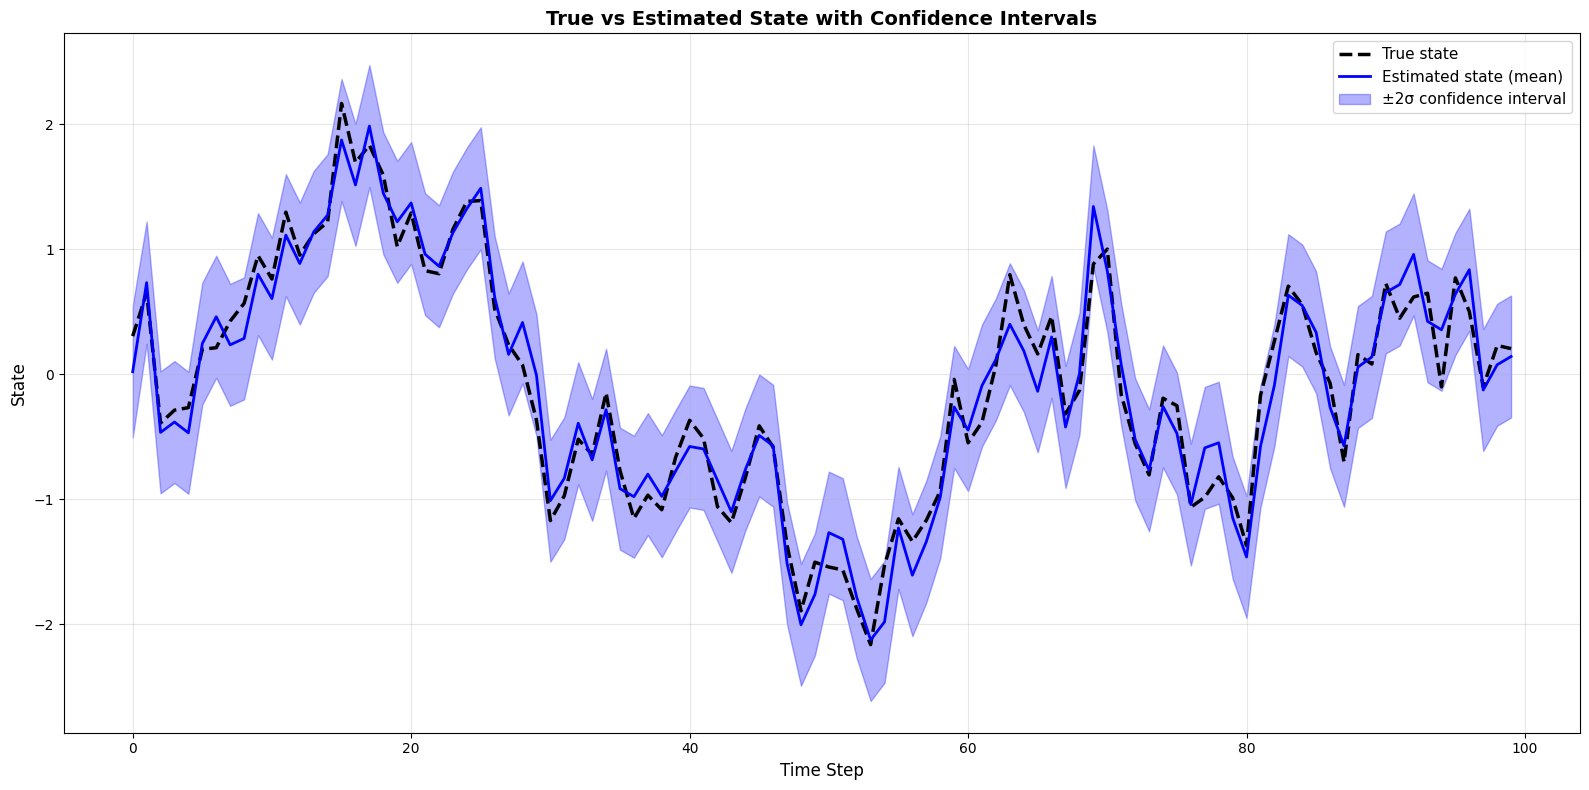

In [5]:
# Generate plots for exp1 (full time range)
# To plot a specific time range, use: plot_method(t_min=start, t_max=end)
# Example: exp1.plot_true_vs_estimated_with_confidence(t_min=50, t_max=100)
exp1.plot_true_vs_estimated_with_confidence(t_min=0, t_max=100,save_path="results/kexp1_plot1.png")



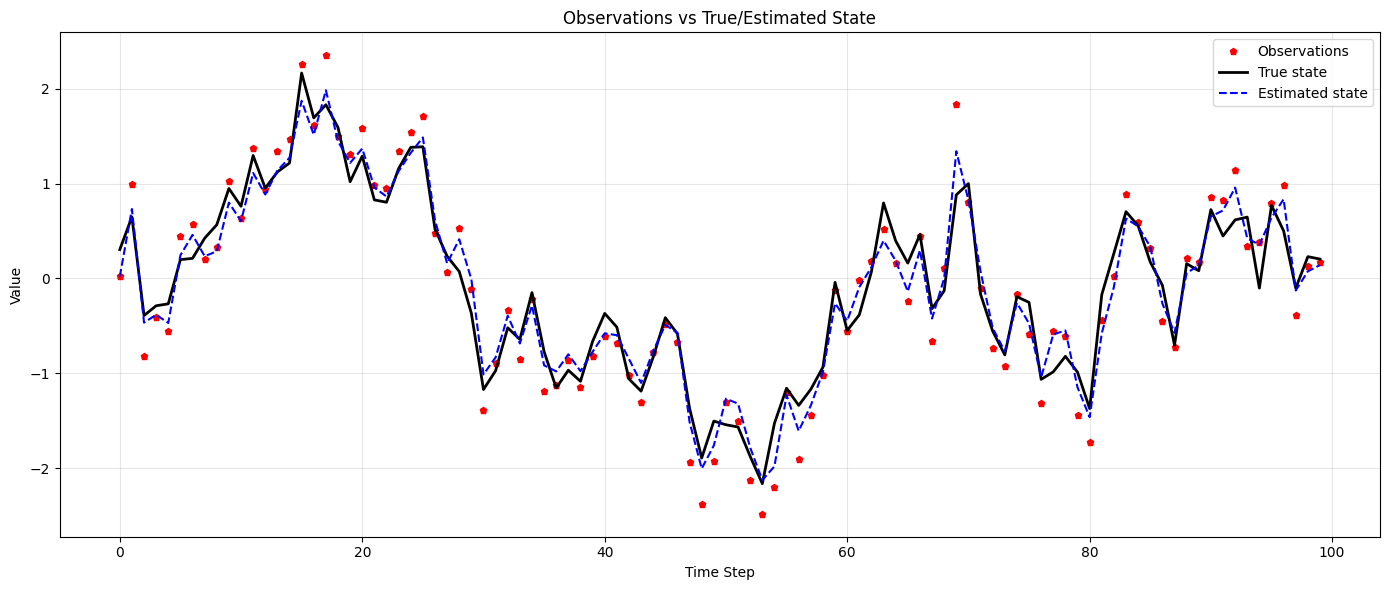

In [6]:
exp1.plot_true_vs_estimated_with_observations(t_min=0, t_max=100,save_path="results/kexp1_plot2.png")


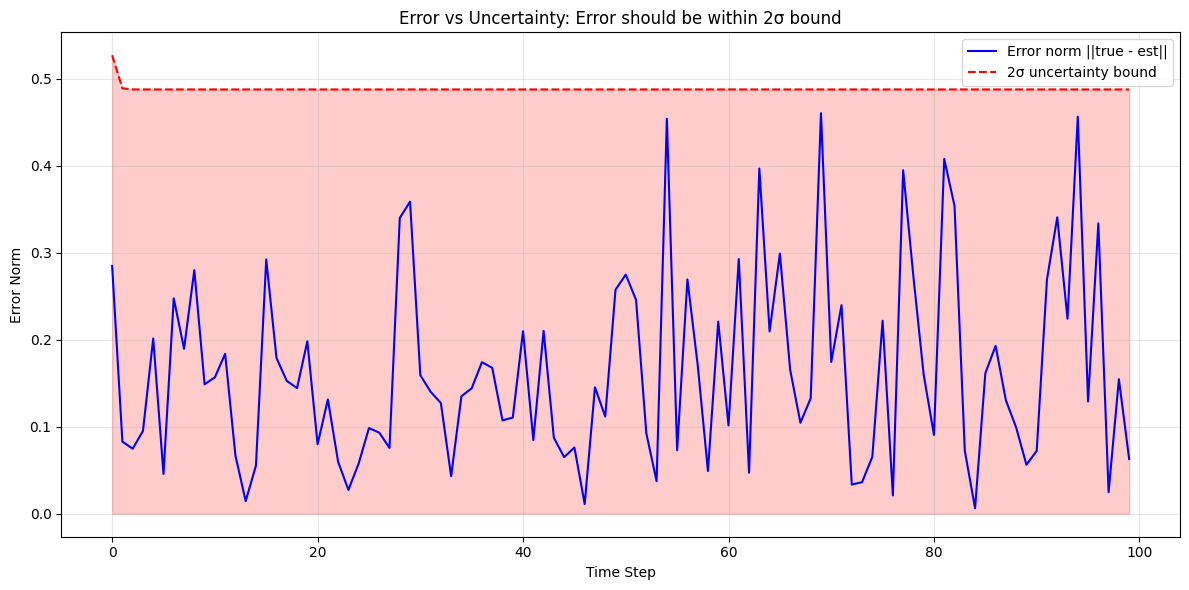

In [7]:
exp1.plot_absolute_error_with_2sigma(t_min=0, t_max=100,save_path="results/kexp1_plot31.png")


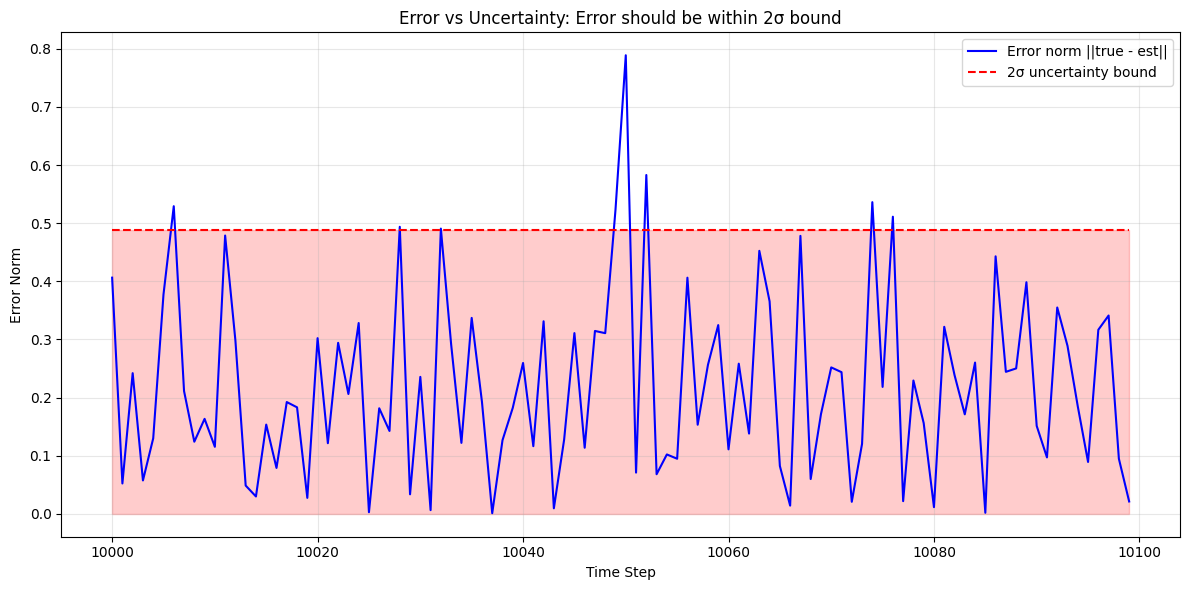

In [8]:
exp1.plot_absolute_error_with_2sigma(t_min=10000, t_max=10100,save_path="results/kexp1_plot32.png")


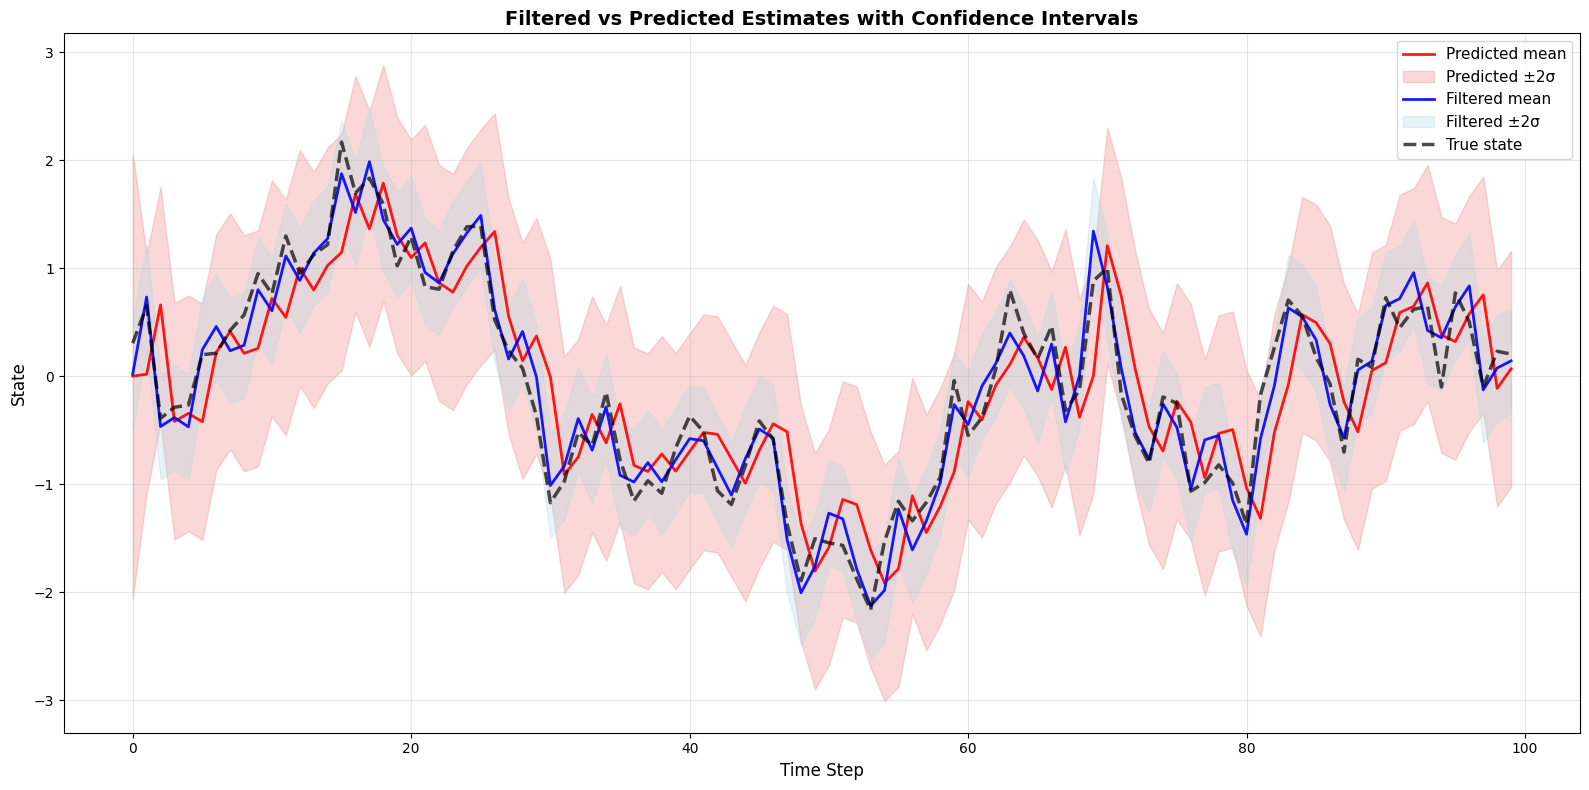

In [9]:
exp1.plot_filtered_vs_predicted(t_min=0, t_max=100,save_path="results/kexp1_plot4.png")

2, The second experiment to demonstrate the effect of Joshsph stablized update. 

In [17]:
# Case 1: Tiny observation noise
params_exp2f= KalmanParams(
    F=np.array([[0.95, 0.0],
                [0.0, 0.95]]),
    B=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    H=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    D=np.array([[1e-8, 0.0],      # Tiny observation noise
                [0.0, 1e-8]]),
    Sigma=np.array([[1.0, 0.0],
                    [0.0, 1.0]]),
    mu_0=np.array([0.0, 0.0]),
    T=500,
    joseph_form=False # Test standard vs Joseph
)

exp2f = Kalmanexperiments(params=params_exp2f)
exp2f.generate_data()
exp2f.run_filter()
exp2f.compute_errors()

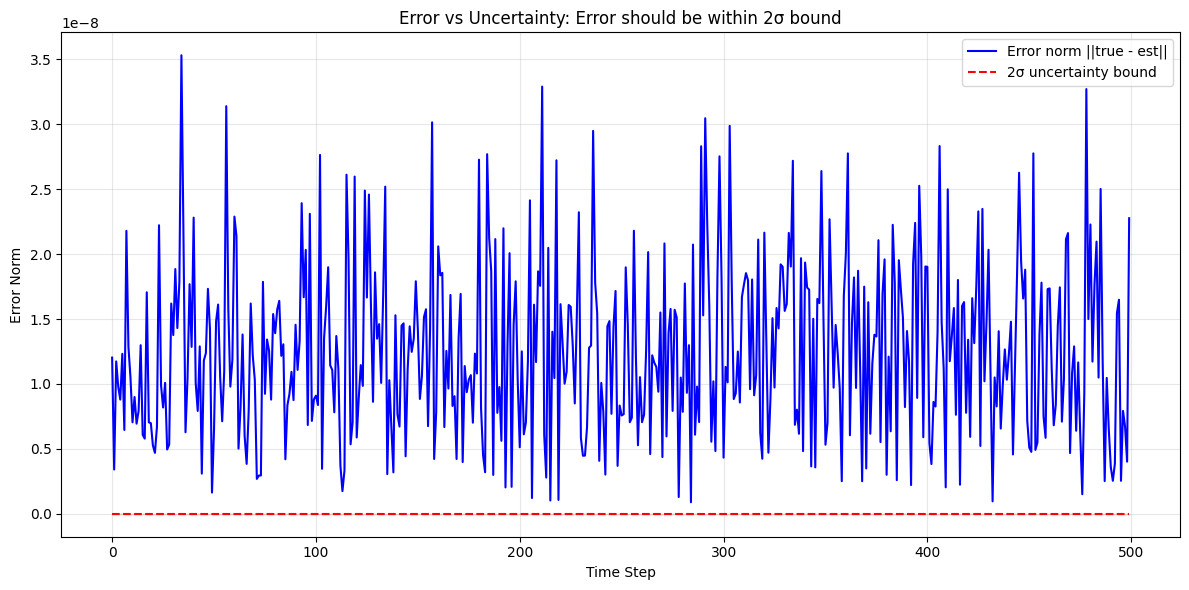

In [18]:
exp2f.plot_absolute_error_with_2sigma(t_min=0, t_max=500,save_path="results/kexp2f_plot3.png")


In [19]:
params_exp2t= KalmanParams(
    F=np.array([[0.95, 0.0],
                [0.0, 0.95]]),
    B=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    H=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    D=np.array([[1e-8, 0.0],      # Tiny observation noise
                [0.0, 1e-8]]),
    Sigma=np.array([[1.0, 0.0],
                    [0.0, 1.0]]),
    mu_0=np.array([0.0, 0.0]),
    T=500,
    joseph_form=True # Test standard vs Joseph
)

exp2t = Kalmanexperiments(params=params_exp2t)
exp2t.generate_data()
exp2t.run_filter()
exp2t.compute_errors()

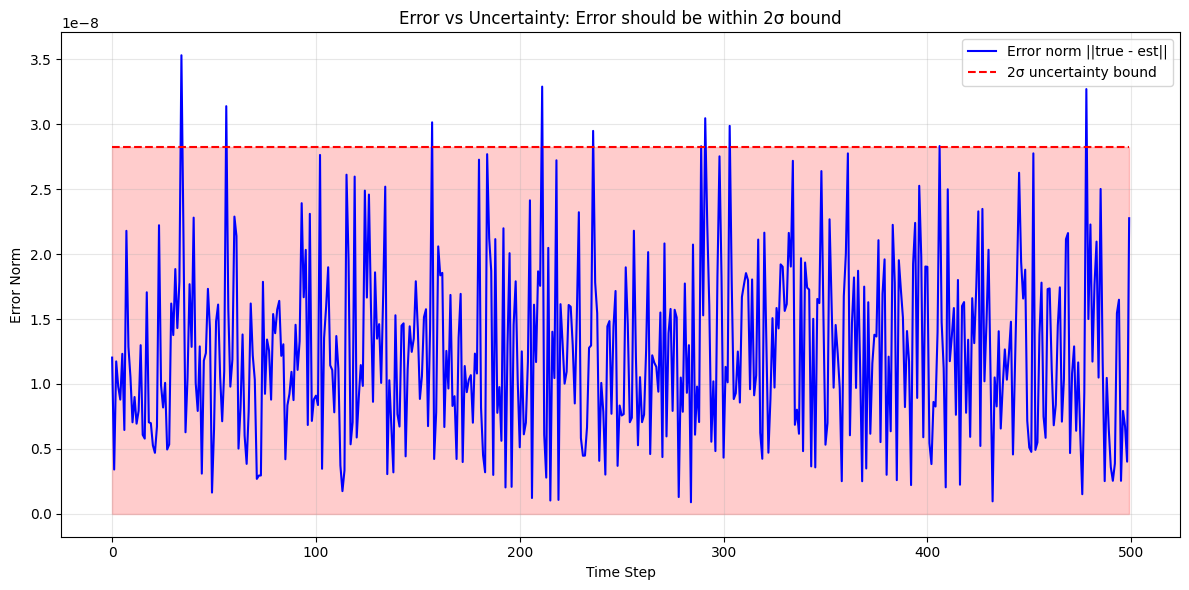

In [20]:
exp2t.plot_absolute_error_with_2sigma(t_min=0, t_max=500,save_path="results/kexp2t_plot3.png")


3, The third experiment with ill-conditioned F matrix (condition number = 99).


In [33]:
# Case 1: Standard form
params_exp3f = KalmanParams(
    F=np.array([[0.9999, 0.0],
                [0.0, 0.0001]]),    # Condition number = 99
    B=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    H=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    D=np.array([[0.1, 0.0],
                [0.0, 0.1]]),
    Sigma=np.array([[1.0, 0.0],
                    [0.0, 1.0]]),
    mu_0=np.array([0.0, 0.0]),
    T=10000,
    joseph_form=False
)

exp3f = Kalmanexperiments(params=params_exp3f)
exp3f.generate_data()
exp3f.run_filter()
exp3f.compute_errors()


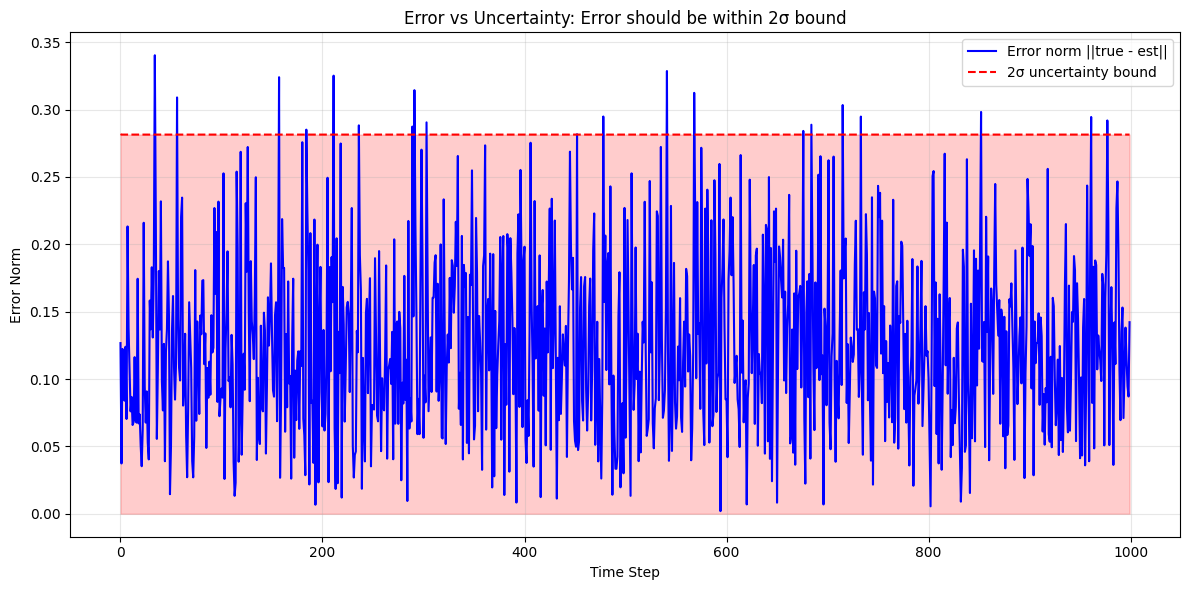

In [34]:
exp3f.plot_absolute_error_with_2sigma(t_min=0, t_max=1000, save_path="results/kexp3f_plot3.png")


In [35]:
# Case 2: Joseph form
params_exp3t = KalmanParams(
    F=np.array([[0.99, 0.0],
                [0.0, 0.01]]),    # Condition number = 99
    B=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    H=np.array([[1.0, 0.0],
                [0.0, 1.0]]),
    D=np.array([[0.1, 0.0],
                [0.0, 0.1]]),
    Sigma=np.array([[1.0, 0.0],
                    [0.0, 1.0]]),
    mu_0=np.array([0.0, 0.0]),
    T=10000,
    joseph_form=True
)

exp3t = Kalmanexperiments(params=params_exp3t)
exp3t.generate_data()
exp3t.run_filter()
exp3t.compute_errors()


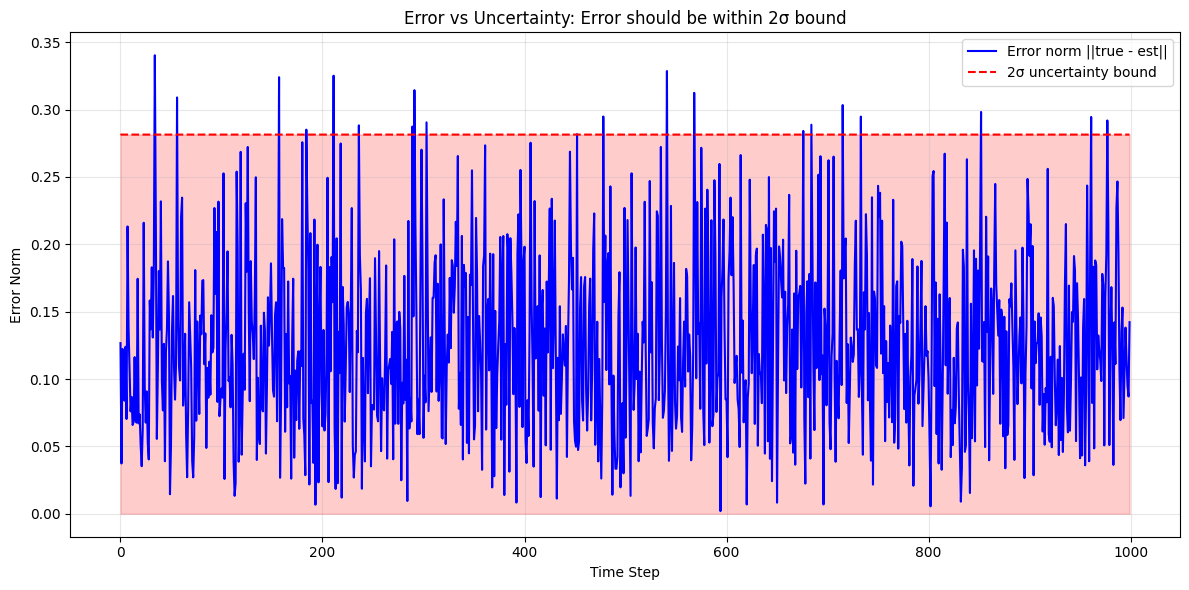

In [36]:
exp3t.plot_absolute_error_with_2sigma(t_min=0, t_max=1000, save_path="results/kexp3t_plot3.png")


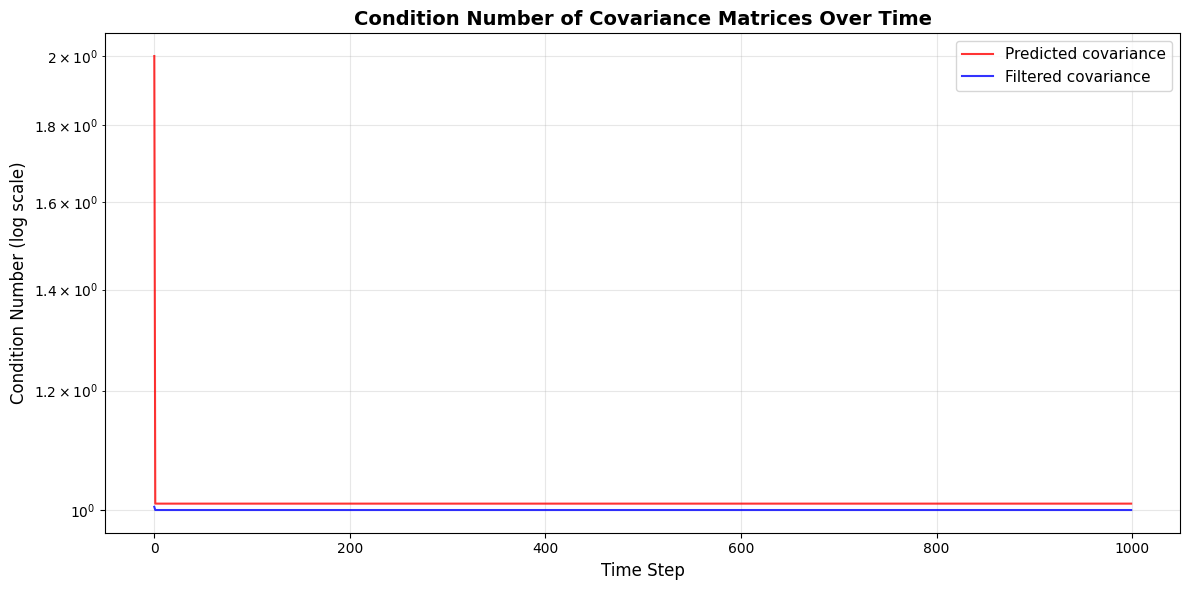

In [32]:
exp3f.plot_condition_number(t_min=0, t_max=1000, save_path="results/kexp3f_plot_cond.png")


In [ ]:
exp3t.plot_condition_number(t_min=0, t_max=1000, save_path="results/kexp3t_plot_cond.png")


5, The fifth experiment with high-dimensional state space (50D) where only 2 dimensions are observed.


In [57]:
# Case 1: Standard form
params_exp5f = KalmanParams(
    F=np.eye(50) * 0.99,           # 50D state
    B=np.eye(50),
    H=np.eye(50)[:2, :],           # Observe first 2 of 50 states
    D=np.eye(2) * 1e-8,            # Tiny noise on observations
    Sigma=np.eye(50),
    mu_0=np.zeros(50),
    T=10000,
    joseph_form=False
)
exp5f = Kalmanexperiments(params=params_exp5f)
exp5f.generate_data()
exp5f.run_filter()
exp5f.compute_errors()


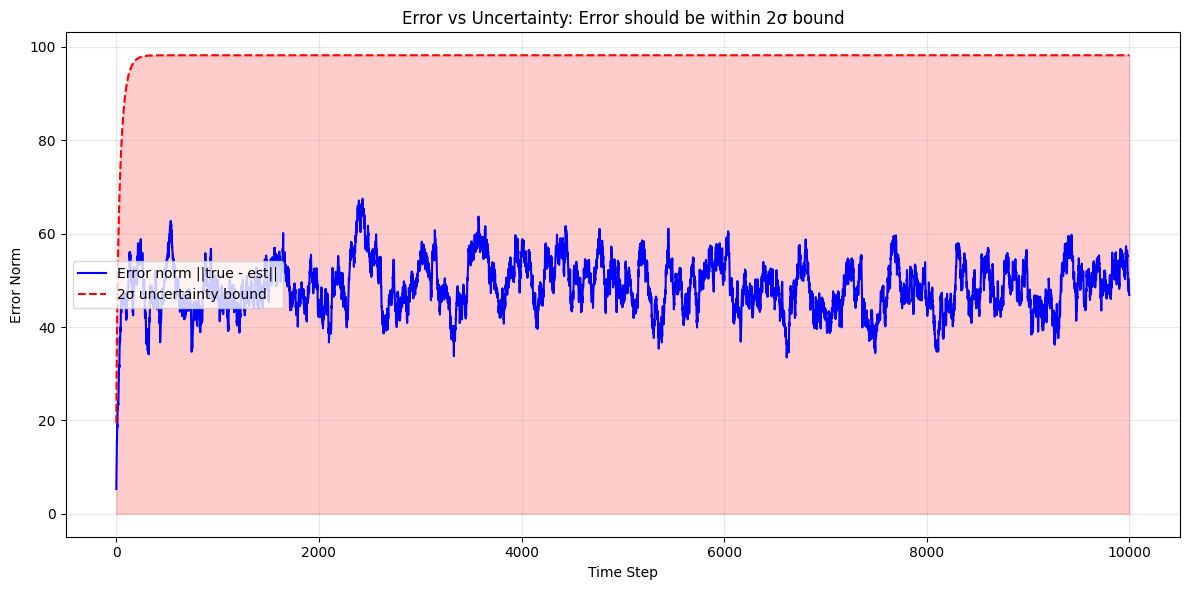

In [58]:
exp5f.plot_absolute_error_with_2sigma(t_min=0, t_max=10000, save_path="results/kexp5f_plot3.png")


In [59]:
# Case 2: Joseph form
params_exp5t =  KalmanParams(
    F=np.eye(50) * 0.99,           # 50D state
    B=np.eye(50),
    H=np.eye(50)[:2, :],           # Observe first 2 of 50 states
    D=np.eye(2) * 1e-8,            # Tiny noise on observations
    Sigma=np.eye(50),
    mu_0=np.zeros(50),
    T=10000,
    joseph_form=True
)

exp5t = Kalmanexperiments(params=params_exp5t)
exp5t.generate_data()
exp5t.run_filter()
exp5t.compute_errors()


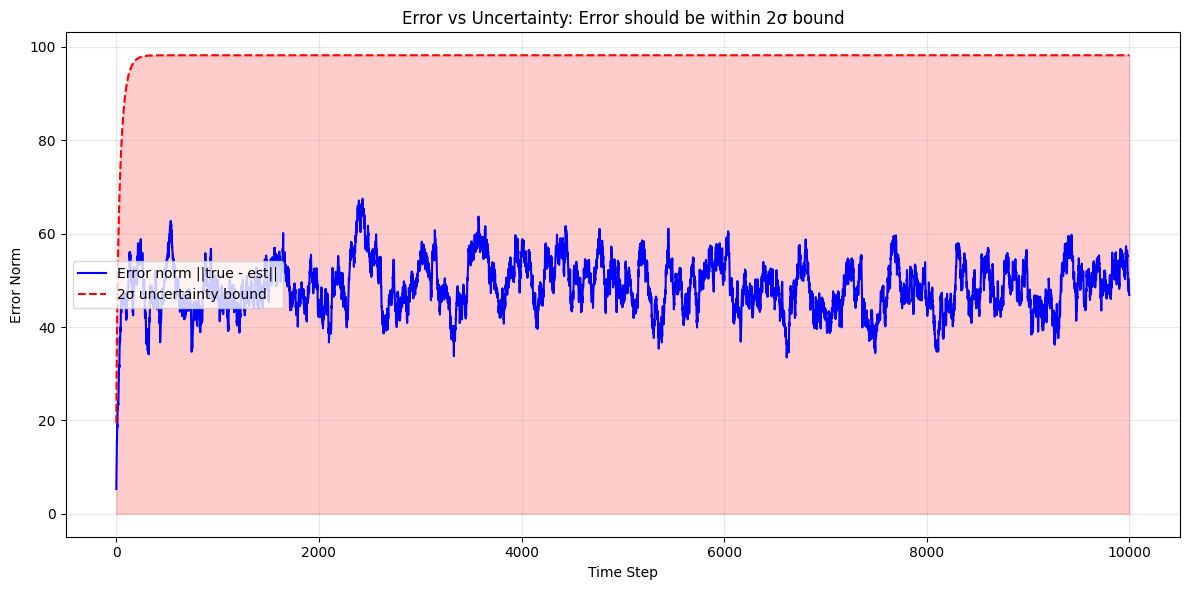

In [60]:
exp5t.plot_absolute_error_with_2sigma(t_min=0, t_max=10000, save_path="results/kexp5t_plot3.png")


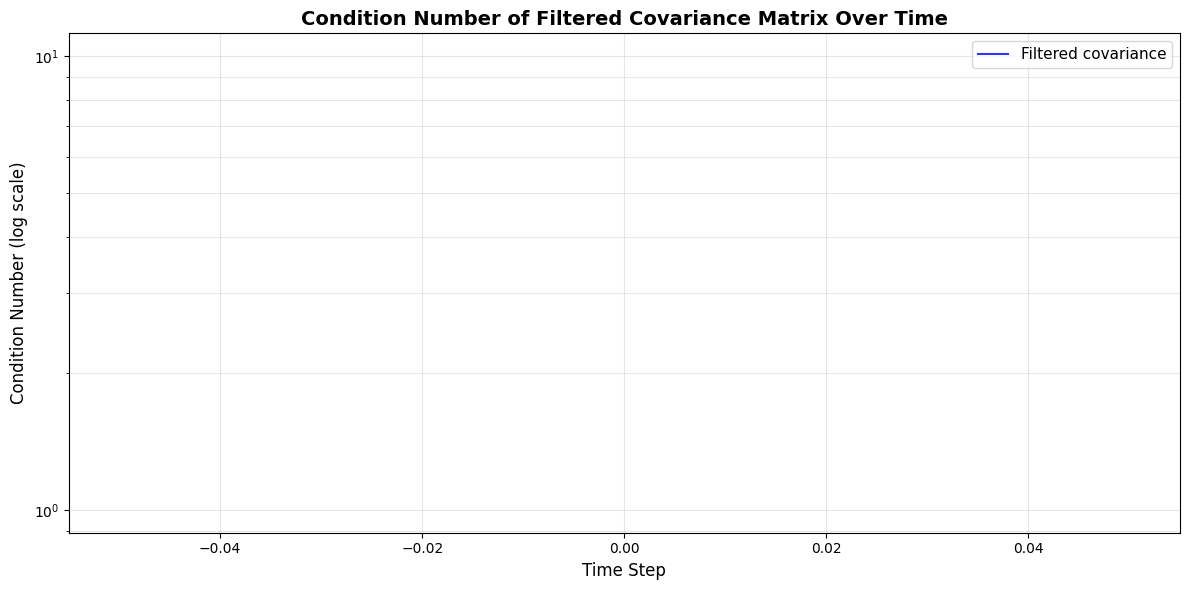

exp5f (Standard form):
Trace: 2412.060301507527
Eigenvalues: [50.25125628 50.25125628 50.25125628 50.25125628 50.25125628 50.25125628
 50.25125628 50.25125628 50.25125628 50.25125628]


In [63]:
exp5f.plot_condition_number(t_min=0, t_max=10000, save_path="results/kexp5f_plot_cond.png")

# Check final covariance matrix for exp5f
P_final_f = exp5f.filtered_covs[-1]
print("exp5f (Standard form):")
print(f"Trace: {np.trace(P_final_f)}")
print(f"Eigenvalues: {np.sort(np.linalg.eigvals(P_final_f))[-10:]}")  # Largest 10


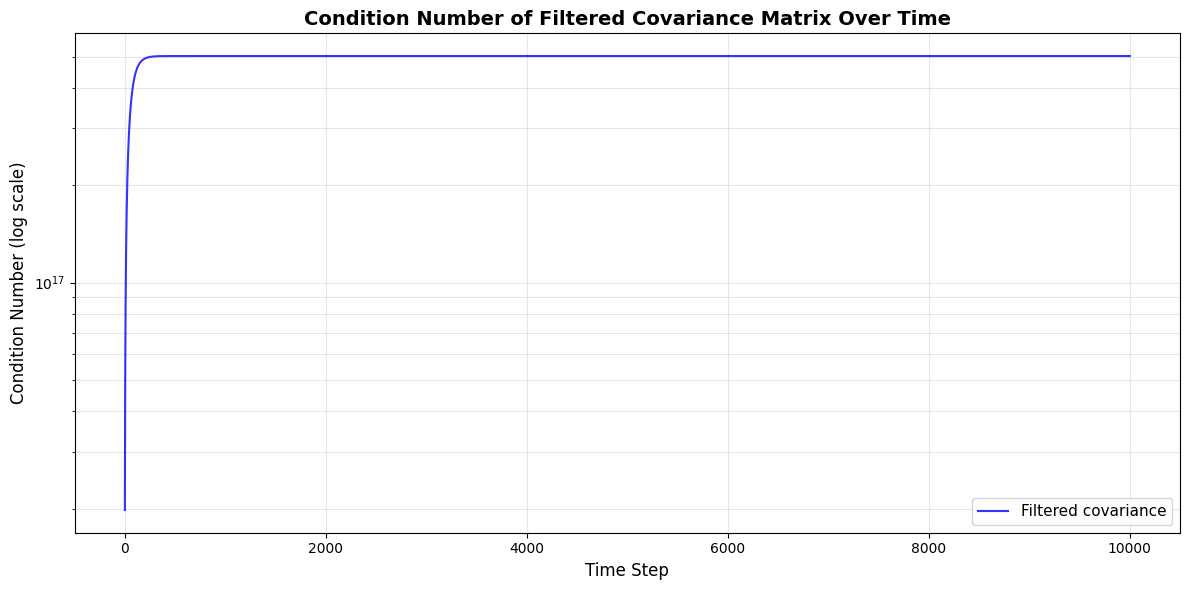

exp5t (Joseph form):
Trace: 2412.060301507527
Eigenvalues: [50.25125628 50.25125628 50.25125628 50.25125628 50.25125628 50.25125628
 50.25125628 50.25125628 50.25125628 50.25125628]


In [64]:
exp5t.plot_condition_number(t_min=0, t_max=10000, save_path="results/kexp5t_plot_cond.png")

# Check final covariance matrix for exp5t
P_final_t = exp5t.filtered_covs[-1]
print("exp5t (Joseph form):")
print(f"Trace: {np.trace(P_final_t)}")
print(f"Eigenvalues: {np.sort(np.linalg.eigvals(P_final_t))[-10:]}")  # Largest 10
